In [69]:
from data_base import *

data = DataBase(summary=True, max_size=10**7)

Whole text size: 36161157 so used 10000000
Alphabet length: 160
Alphabet:  !"#%&'()*,-./0123456789:;<=>?@[]^_`abcdefghijklmnopqrstuvwxyz{|}~§«°·»½¾ßàáâäçèéêëíîïòóôöùúûüýœ̀́γεθιλοστυώабвгдежзийклмнопрстуфхцчшщъыьэюяёєіїљќѣ‑–—’“”„…№


In [70]:
import numpy as np

def match_to_letters(prediction):
    return {data.alphabet[i]: prediction[i] for i in range(data.alph_len)}

def letter_of_pred(prediction) -> str:
    return data.alphabet[prediction.argmax()]

def sorted_need_letters(prediction, need):
    pr = match_to_letters(prediction)
    pr = list(sorted(pr.items(), key=lambda x: x[1]))
    pr = [x for x in pr if x[0] in need]
    return pr
    

class LetterCounter:
    def __init__(self):
        self.one_letter_counter = np.zeros((data.alph_len,), dtype=np.int32)
        self.counter = np.zeros((data.alph_len, data.alph_len), dtype=np.int32)

    def correlate(self, prev, next):
        prev_ind = data.letter_index[prev]
        next_ind = data.letter_index[next]
        self.one_letter_counter[prev_ind] += 1
        self.counter[prev_ind][next_ind] += 1
    
    def letter_distribution(self):
        normed_olc = self.one_letter_counter / np.sum(self.one_letter_counter)
        return match_to_letters(normed_olc)

    def predict_raw(self, prev):
        prev_ind = data.letter_index[prev]
        return self.counter[prev_ind]
    
    def predict_unif(self, prev):
        preds = self.predict_raw(prev)
        total = preds.sum()
        return preds / total
    
    def predict_next(self, prev):
        return letter_of_pred(self.predict_raw(prev))

    def get_rate(self, prev, next):
        return self.counter[data.letter_index[prev]][data.letter_index[next]]

    def get_poss_rate(self, prev, next):
        return self.counter[data.letter_index[prev]][data.letter_index[next]] / self.counter.sum()


class SimpleModel(LetterCounter):
    def __init__(self, frag_len):
        super().__init__()
        self.frag_len = frag_len
        self.counters = [LetterCounter() for _ in range(frag_len)]

    def correlate(self, prev_frag, next):
        next_ind = data.letter_index[next]

        for i in range(self.frag_len):
            prev_ind = data.letter_index[prev_frag[i]]
            self.counters[i].counter[prev_ind][next_ind] += 1
            self.counter[prev_ind][next_ind] += 1
            self.counters[i].one_letter_counter[prev_ind] += 1

    def predict_raw(self, prev_frag):
        defect = 0
        #defect = self.frag_len - len(prev_frag)
        #prev_frag = ' '*defect + prev_frag

        preds = np.zeros(data.alph_len)
        
        for i in range(defect, self.frag_len):
            preds += self.counters[i].predict_raw(prev_frag[i])

        return preds


FRAGMENT_LEN = 3
simple_model = SimpleModel(FRAGMENT_LEN)

for i in tqdm(range(FRAGMENT_LEN, data.text_size)):
    simple_model.correlate(data.whole_text[i-FRAGMENT_LEN : i], data.whole_text[i])


  0%|          | 0/9999997 [00:00<?, ?it/s]

100%|██████████| 9999997/9999997 [01:25<00:00, 117390.36it/s]


In [71]:
import pandas as pd
import json

# Saving data

#json.dump(simple_model.counter, open('correlation data.json', 'w'))

df = pd.DataFrame(simple_model.counters[-1].counter, index=data.alphabet, columns=data.alphabet)
df.to_csv('data/correlation data.csv', sep='\t')

# so df.loc['а', 'в'] == df['в', 'а'] == data.whole_text.count('ав') == simple_model.counter['в']['а'] == 99253

In [72]:
need_alph = list(' абвгдеёжзийклмнопрстуфхцчшщъыьэюя.,!?-')

#data_fr = df.loc[need_alph, need_alph]
data_fr = df.loc[:, :]

data_fr.loc[need_alph, need_alph].head()

,,а,б,в,г,д,е,ё,ж,з,...,ы,ь,э,ю,я,.,",",!,?,-
,0,22944,64236,151174,36722,70810,36653,2,21843,41673,...,0,0,21262,1561,33022,358,3,4,1,13162
а,117859,55,5812,26937,6828,17779,11616,37,12532,29123,...,0,0,45,8747,17304,10621,23853,2767,1476,1511
б,3142,6788,51,934,10,183,20218,17,37,13,...,33789,472,2,32,5835,91,204,20,9,30
в,46324,53076,102,409,327,5108,46474,128,0,3892,...,24246,2228,0,8,2368,2021,4140,211,154,126
г,6938,9412,14,55,9,11406,4016,0,0,9,...,11,1,0,4,0,471,1143,88,52,56


In [73]:
print("Probability of the next one after the previous one")
next_to_prev = data_fr.div(data_fr.sum(axis=1), axis=0)
next_to_prev = next_to_prev.apply(lambda x: round(x*100, 2))
next_to_prev.loc[need_alph, need_alph].head()

Probability of the next one after the previous one


,,а,б,в,г,д,е,ё,ж,з,...,ы,ь,э,ю,я,.,",",!,?,-
,0.00,1.42,3.96,9.33,2.27,4.37,2.26,0.00,1.35,2.57,...,0.00,0.00,1.31,0.10,2.04,0.02,0.00,0.00,0.00,0.81
а,18.63,0.01,0.92,4.26,1.08,2.81,1.84,0.01,1.98,4.60,...,0.00,0.00,0.01,1.38,2.74,1.68,3.77,0.44,0.23,0.24
б,2.23,4.83,0.04,0.66,0.01,0.13,14.37,0.01,0.03,0.01,...,24.02,0.34,0.00,0.02,4.15,0.06,0.15,0.01,0.01,0.02
в,12.85,14.72,0.03,0.11,0.09,1.42,12.89,0.04,0.00,1.08,...,6.73,0.62,0.00,0.00,0.66,0.56,1.15,0.06,0.04,0.03
г,4.80,6.52,0.01,0.04,0.01,7.90,2.78,0.00,0.00,0.01,...,0.01,0.00,0.00,0.00,0.00,0.33,0.79,0.06,0.04,0.04


C:\Users\CA81~1\AppData\Local\Temp/ipykernel_29352/1628655845.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


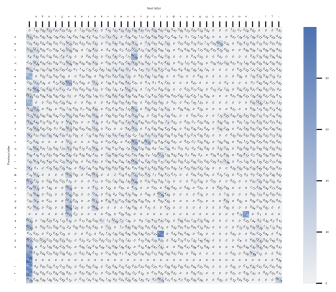

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

sns.set_context('notebook')
sns.set_style("ticks")

sns.set(font_scale=0.25)

ax = sns.heatmap(next_to_prev.loc[need_alph, need_alph],
                 annot=True, fmt='g', annot_kws={'rotation': -30},
                 square=True, xticklabels=True, yticklabels=True,
                 cmap=sns.color_palette("light:b", as_cmap=True))

ax.xaxis.tick_top()
ax.set(ylabel="Previous letter")
ax.set_title("Next letter")
plt.tight_layout()
plt.show()

In [75]:
letters_predicted = 0
predictability = 0
n = 100_000
#n = data.text_size

for i in tqdm(range(FRAGMENT_LEN, n)):
    text_fragment = data.whole_text[i-FRAGMENT_LEN : i]

    predictability += match_to_letters(simple_model.predict_unif(text_fragment))[data.whole_text[i]]
    letters_predicted += 1 if simple_model.predict_next(text_fragment) == data.whole_text[i] else 0

predictability /= n - FRAGMENT_LEN
letters_predicted /= n - FRAGMENT_LEN
print('Predicted ', round(letters_predicted*100, 2), '% of letters')
print('Predictability of russian language is', round(predictability*100, 2), '%')
    

100%|██████████| 99997/99997 [00:07<00:00, 13541.83it/s]

Predicted  18.99 % of letters
Predictability of russian language is 8.32 %


In [76]:
#test_text = 'приветики, съешь ещё этих мягких французских булочек да выпей чаю'
#test_text = 'и снова седая ночь, и только ей доверяю я, знаешь седая ночь что-то та-а-ам'
#test_text = 'мне нужно это предложение, чтобы протестировать некий анализ йей!'
#test_text = prepare_text("Если посмотреть из чего получается оригинальная мысль, то можем выделить следующие факторы: личные ценности, культурный опыт, перспектива и взгляд на мир, эмоциональные и интуитивные компоненты. Из этого и складывается индивидуальность творца-человека. ИИ не обладает эмоциями. Но что из этого не может быть имитировано? Он не может обладать ничем из перечисленного, ведь это все присуще живым и мыслящим существам, а ИИ не живой; однако он может все это впитать и воссоздать в себе. Эти факторы – следствие всего пережитого, всего накопленного и отпечатанного опыта. А впитывать опыт – то, что ИИ и делают и способны делать это лучше нас и в гораздо большем объеме, чем способны люди, ведь ИИ не органичен физиологическими факторами.")
test_text = prepare_text("Если посмотреть из чего получается оригинальная мысль, то можем выделить следующие факторы: личные ценности, культурный опыт, перспектива и взгляд на мир, эмоциональные и интуитивные компоненты. Из этого и складывается индивидуальность творца-человека. ИИ не обладает эмоциями. Но что из этого не может быть имитировано? Он не может обладать ничем из перечисленного, ведь это все присуще живым и мыслящим существам, а ИИ не живой; однако он может все это впитать и воссоздать в себе. Эти факторы - следствие всего пережитого, всего накопленного и отпечатанного опыта. А впитывать опыт - то, что ИИ и делают и способны делать это лучше нас и в гораздо большем объеме, чем способны люди, ведь ИИ не органичен физиологическими факторами.")

r = test_text[:FRAGMENT_LEN]
for i in range(FRAGMENT_LEN, len(test_text)):
    #if match_to_letters(simple_model.predict_unif(test_text[i-FRAGMENT_LEN : i]))[test_text[i]] > 0.09 and test_text[i] != ' ':
    if match_to_letters(simple_model.predict_unif(r[-FRAGMENT_LEN:]))[test_text[i]] > 0.07 and test_text[i] != ' ':
    #if simple_model.predict_next(test_text[i-FRAGMENT_LEN : i]) == test_text[i] and test_text[i] != ' ':
    #if simple_model.predict_next(r[-FRAGMENT_LEN:]) == test_text[i] and test_text[i] != ' ':
        r += ''
    else:
        r += test_text[i]

print(r)
print('Original length:', len(test_text))
print('Compressed length:', len(r))
print('Compression:', len(r) / len(test_text))

есл псмтрть из чг олучся оригнльня мысль, т мжм ыдлть лдующ фктры: личные цннси, культурный опыт, ерспктив и взгляд а мир, эмционльные и интуитивные кмпннты. из эг и склдывтся индивидуаьнсь тврца-члвк. ии е бладт эмциями. о чт из эг е мжт быт имитирвн? он н мжт облдт ичм из ерчислннг, едь эт е присущ живым и мыслящм ущсвм, а ии е живй; однк он мжт е эт итать и вссздт  сб. эи фктры - лдсвие всг ержитг, ег акплннг и тпечннг опыт. а впитывть опыт - т, ч ии и длают и спсбны длат эт лучш ас и в грзд бльшм объем, чм осбны люд, едь ии е рганчн физиолгичским фктрми.
Original length: 734
Compressed length: 564
Compression: 0.7683923705722071


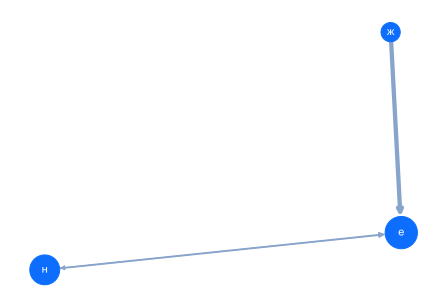

In [77]:
import networkx as nx
import matplotlib.pyplot as plt

g = nx.DiGraph(directed=True)

need_symbs = 'йцукенгшщзхъфывапролджэячсмитьбюё'

current_node = 'ж'
i = 0
while i < 10:
	pred = simple_model.counters[-1].predict_unif(current_node)
	pred = sorted_need_letters(pred, need_symbs)
	b = pred[-1][0]

	w = pred[-1][1]*10

	g.add_edge(current_node, b, weight=w)

	current_node = b
	i += 1

weights = [g[u][v]['weight'] for u, v in g.edges]

letter_counts = simple_model.counters[-1].letter_distribution()

node_sizes = [letter_counts[v[0]]**0.5 * 4000 for v in g.degree]

options = {
    'node_color': '#0d6efd',
    'font_color': '#fff',
    'edge_color': '#89a4cb',
    'font_size': 11, 
}

nx.draw(g, with_labels=True, width=weights, node_size=node_sizes, arrows=True, **options)

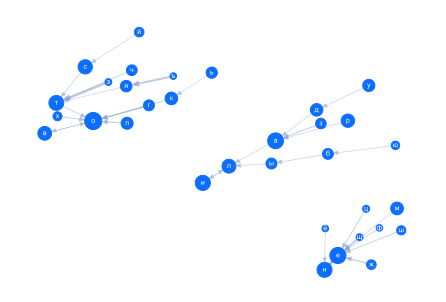

In [127]:
g = nx.DiGraph(directed=True)

for l in need_symbs:
	pred = simple_model.counters[-1].predict_unif(l)
	pred = sorted_need_letters(pred, need_symbs)

	p = pred[-1]
	a = p[0]
	w = min(max(p[1], 0.2), 0.8) * 3

	g.add_edge(l, a, weight=w)

weights = [g[u][v]['weight'] for u, v in g.edges]
node_sizes = [max(letter_counts[v[0]], 0.002)**0.5 * 1000 for v in g.degree]

options = {
    'node_color': '#0d6efd',
    'font_color': '#fff',
    'edge_color': '#89a4cb88',
    'font_size': 7, 
}

nx.draw(g, with_labels=True, width=weights, node_size=node_sizes, arrows=True, **options)

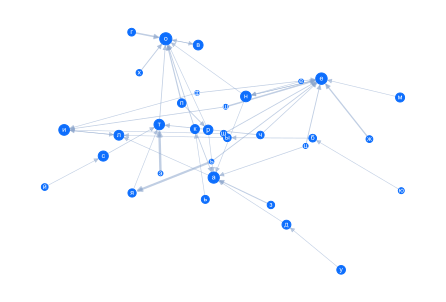

In [146]:
g = nx.DiGraph(directed=True)

n = 10

for l in need_symbs:
	pred = simple_model.counters[-1].predict_unif(l)
	pred = sorted_need_letters(pred, need_symbs)

	for i in range(n):
		p = pred[-1 - i]
		a = p[0]
		w = min(max(p[1], 0.2), 0.8) * 3

		g.add_edge(l, a, weight=w)

		if (pred[-1 - i - 1][1] < 0.18): break

weights = [g[u][v]['weight'] for u, v in g.edges]
node_sizes = [max(letter_counts[v[0]], 0.002)**0.5 * 500 for v in g.degree]

options = {
    'node_color': '#0d6efd',
    'font_color': '#fff',
    'edge_color': '#89a4cb88',
    'font_size': 7, 
}

nx.draw(g, with_labels=True, width=weights, node_size=node_sizes, arrows=True, **options)

In [125]:
def discover_patterns(buffer, lim, gamma):
    buff = []
    for p in buffer:
        pred = simple_model.counters[-1].predict_unif(p[-1])
        pred = sorted_need_letters(pred, need_symbs)

        i = 0
        while pred[-1 - i][1] * simple_model.counters[-1].get_poss_rate(p[-1], pred[-1 - i][0]) > lim:
            l = pred[-1 - i][0]
            #if p.count(l) < 2: buff.append(p + l)
            if l not in p: buff.append(p + l)
            i += 1

    if buff == []: return buffer

    return discover_patterns(buff, lim/gamma, gamma) + buffer

def rate_poss(s):
    r = 0
    for i in range(1, len(s)):
        pr = match_to_letters(simple_model.counters[-1].predict_unif(s[i-1]))
        v = simple_model.counters[-1].get_rate(s[i-1], s[i])
        r += pr[s[i]] * v

    return r**0.5

patterns = discover_patterns(list(need_symbs), 0.0005, 0.8)
rated_patterns = [(p, rate_poss(p)) for p in patterns]
rated_patterns = sorted(rated_patterns, key=lambda x: x[1])

for ns in need_symbs:
    print(ns, [p for p in rated_patterns if p[0][0] == ns and len(p[0]) > 1])



й []
ц []
у []
к [('ка', 127.95541313665107), ('ко', 142.5401439083641), ('кал', 156.8413466668269), ('кали', 183.76835049373537)]
е [('ен', 83.51504191047782), ('ени', 124.98438355156863), ('ено', 152.82946599452646), ('ена', 158.7025043711049), ('енал', 182.7925194502042)]
н [('ни', 92.98566505895815), ('но', 127.99251326098434), ('на', 134.95081573800027), ('не', 136.07393980285843), ('нал', 162.5987175276743), ('нали', 188.70596588494232)]
г [('го', 195.1515284727711)]
ш [('ше', 73.24915060789061), ('шен', 111.08645412509263), ('шени', 144.86729857543094), ('шено', 169.4764990815823), ('шена', 174.79108374982408)]
щ [('ще', 75.94246428555468), ('щен', 112.88055681591766), ('щени', 146.24757780397036), ('щено', 170.65785524825648), ('щена', 175.93675788596116)]
з [('за', 122.041103478995), ('зал', 152.0547638571823), ('зали', 179.70044471449722)]
х [('хо', 79.5797009474426)]
ъ []
ф []
ы []
в [('ве', 77.40744258337354), ('ва', 88.40378324558105), ('во', 103.67906955474572), ('вен', 1